In [1]:
from skimage import io
from matplotlib import pylab as plt
from math import pi
import numpy as np

In [10]:
# input parameters
alfa = 1
detectors = 180 
phi = 180
filtering = True
animation = True

# other parameters
theta = 180.
images = ['Kolo.jpg', 'Kropka.jpg', 'Kwadraty2.jpg', 'Paski2.jpg', 'Shepp_logan.jpg', 'SADDLE_PE.JPG', 'CT_ScoutView.jpg']
image = io.imread('tomograf-zdjecia/' + images[4], as_gray = True)

Błąd średniokwadratowy:  0.1869096373900469


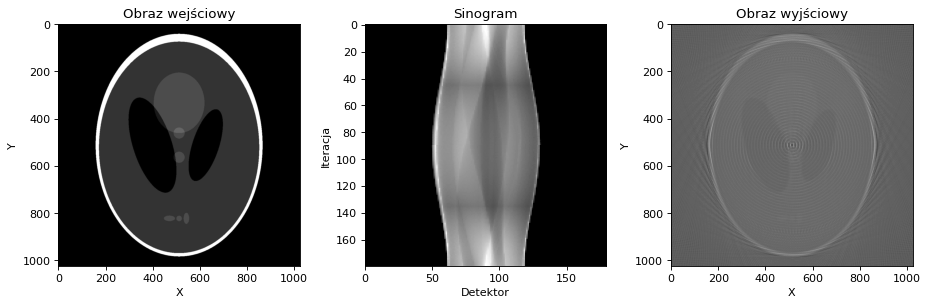

In [11]:
def getParallelEmittersPositions(angle):
    angle = np.deg2rad(angle)
    phi_rad = np.deg2rad(phi)
    positions = []
    r = max(image.shape) * np.sqrt(2) / 2
    center = max(image.shape) / 2

    for i in range(detectors):
        x = int(r * np.cos(angle + phi_rad / 2 - i * (phi_rad / (detectors - 1))) + center)
        y = int(r * np.sin(angle + phi_rad / 2 - i * (phi_rad / (detectors - 1))) + center)
        positions.append([x, y])

    return positions

def getDetectorsPositions(angle): 
    angle_rad = np.deg2rad(angle)
    phi_rad = np.deg2rad(phi)
    positions = []
    r = max(image.shape) * np.sqrt(2) / 2 
    center = max(image.shape) / 2
    
    for i in range(detectors):
        x = int(r * np.cos(angle_rad + np.pi - phi_rad / 2 + i * (phi_rad / (detectors - 1))) + center) 
        y = int(r * np.sin(angle_rad + np.pi - phi_rad / 2 + i * (phi_rad / (detectors - 1))) + center)
        positions.append([x, y])
    
    return positions

def applyBresenhamAlgorithm(x0, y0, x1, y1): 
    delta_x = x1 - x0
    delta_y = y1 - y0     
    x_direction = 1
    y_direction = 1
    line = []
    
    if delta_x < 0:
        delta_x, x_direction = abs(delta_x), -1     
                                                       
    if delta_y < 0:
        delta_y, y_direction = abs(delta_y), -1    
    
    error = delta_y - delta_x 
    y = y0 
    x = x0 
        
    if delta_x > delta_y:
        for _ in range(delta_x):
            line.append([x, y])
            if error >= 0:
                y += y_direction
                error -= delta_x
            x += x_direction
            error += delta_y
    else:
        for _ in range(delta_y):
            line.append([x, y])
            if error >= 0:
                x += x_direction
                error -= delta_y
            y += y_direction
            error += delta_x
    
    return line

def isCorrectPoint(x, y):
    if x >= 0 and y >= 0 and x < image.shape[0] and y < image.shape[1]:
        return True
    return False

def createFilterMask():
    mask = []
    mask_size = 9
    
    if mask_size % 2 == 0:
        mask_size += 1
    
    for k in range(- mask_size // 2 + 1, mask_size // 2 + 1, 1):
        if k == 0:
            mask.append(1)
        elif k % 2 == 0:
            mask.append(0)
        else:
            mask.append((-4 / (pi * pi)) / (k * k))
    
    return mask 

def filterImage(sinogram):
    mask = createFilterMask()
    
    for i in range(sinogram.shape[0]):
        sinogram[i, :] = np.convolve(sinogram[i, :], mask, 'same')
        
    return sinogram

def normalize(array):
    max_value = np.amax(array)
    
    if max_value == 0:
        return array
    
    array_normalized = [value / max_value for value in array]
    
    return array_normalized

'''def normalize1(array):             
    min_value = np.amin(array)
    max_value = np.amax(array)
    
    if min_value == max_value:
        return array
    
    for i in range(len(array)):
        for j in range(len(array[i])):
            array[i][j] = (array[i][j] - min_value) / (max_value-min_value)
            
    return array'''

def applyRadonTransform():    
    sinogram = []
    angles = np.linspace(0., theta, int(theta / alfa), endpoint=False)
    
    for angle in angles:
        em_pos = getParallelEmittersPositions(angle)
        det_pos = getDetectorsPositions(angle)
        detectors_output = []
        
        for em, det in zip(em_pos, det_pos):
            pixels_sum = 0
            line = applyBresenhamAlgorithm(em[0], em[1], det[0], det[1])
            
            for point in line:
                if isCorrectPoint(point[0], point[1]):
                    pixels_sum += image[point[0], point[1]]         
                                                                    
            detectors_output.append(pixels_sum)
        
        sinogram.append(detectors_output)
         
    return normalize(sinogram) 

def applyInverseRadonTransform(sinogram):           
    output = np.zeros((image.shape[0], image.shape[1]))
    angles = np.linspace(0., theta, int(theta / alfa), endpoint=False)
    
    if filtering:
        sinogram = filterImage(sinogram.copy())
    
    for i, angle in enumerate(angles):
        em_pos = getParallelEmittersPositions(angle)
        det_pos = getDetectorsPositions(angle)
        
        for j, (em, det) in enumerate(zip(em_pos, det_pos)):
            line = applyBresenhamAlgorithm(em[0], em[1], det[0], det[1])
            pixels_sum = sinogram[i][j]
            
            for point in line:                 
                if isCorrectPoint(point[0], point[1]):
                    output[point[0], point[1]] += pixels_sum     
        
    return normalize(output)

def calculateRootMeanSquaredError(output):
    rmse = 0.0
    n = image.shape[0] * image.shape[1]
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rmse += (image[i][j] - output[i][j]) ** 2  # overflow?
            
    return np.sqrt(rmse / n)         

def main():
    sinogram = np.array(applyRadonTransform())
    output = applyInverseRadonTransform(sinogram)
    
    rmse = calculateRootMeanSquaredError(output)
    print("Błąd średniokwadratowy: ", rmse)
    
    fig = plt.figure(figsize=(14, 4), dpi=80)   
    ax = fig.add_subplot(131)
    ax.set_title('Obraz wejściowy')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.imshow(image, cmap = 'gray')
    
    ax = fig.add_subplot(132)
    ax.set_title('Sinogram')
    ax.set_ylabel('Iteracja')      
    ax.set_xlabel('Detektor')
    ax.imshow(sinogram, cmap = 'gray')
    
    ax = fig.add_subplot(133)
    ax.set_title('Obraz wyjściowy')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.imshow(output, cmap = 'gray')
    
    return rmse

if __name__ == '__main__':
    main()

In [ ]:
# generowanie wykresów do sprawozdania

x_values = [i for i in range(90, 721, 90)]
# x_values = [i for i in range(45, 271, 45)]
y_values = [0 for _ in range(len(x_values))]

for i, value in enumerate(x_values):
    detectors = value
    # phi = value
    # alfa = ?
    y_values[i] = main()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Wartość RMSE od liczby detektorów')
# ax.set_title('Wartość RMSE od liczby skanów')
# ax.set_title('Wartość RMSE od rozpiętości wachlarza')
ax.set_xlabel('liczba detektorów')
# ax.set_xlabel('liczba skanów')
# ax.set_xlabel('rozpiętość wachlarza')
ax.set_ylabel('RMSE')
ax.plot(x_values, y_values)